In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dummy Data ---
cycles = np.arange(1, 11)

flow = {
    "Lane A": np.array([12, 14, 13, 15, 16, 14, 15, 17, 16, 18]),
    "Lane B": np.array([18, 20, 21, 19, 22, 20, 21, 23, 22, 24]),
    "Lane C": np.array([10,  9, 11, 12, 10, 11, 12, 13, 12, 14])
}

avg_speed = {
    "Lane A": np.array([12, 11, 12, 13, 12, 11, 12, 13, 12, 14]),
    "Lane B": np.array([10, 11, 10, 12, 11, 10, 11, 12, 11, 12]),
    "Lane C": np.array([15, 14, 15, 16, 15, 14, 15, 16, 15, 16])
}


# --- (use your existing flow & avg_speed dicts and cycles array) ---
# lanes, flow, avg_speed, cycles already defined above in your script

lanes = list(flow.keys())
n_lanes = len(lanes)
n_cycles = len(cycles)

# Parameters
cycle_time = 60.0   # seconds per cycle
alpha = 0.3         # EMA smoothing factor
min_green = 10.0     # seconds minimum per lane
max_green = 90.0    # seconds maximum per lane
speeds_in_kmph = False   # <-- set True if your avg_speed values are in km/h

# --- Step 1: compute per-cycle densities (rho = Q / v) ---
density = np.zeros((n_cycles, n_lanes))  # shape (cycles, lanes)

for t in range(n_cycles):
    for j, lane in enumerate(lanes):
        Q_s = flow[lane][t] / cycle_time    # veh/s
        v = avg_speed[lane][t]
        if speeds_in_kmph:
            v = v / 3.6   # convert km/h -> m/s
        # avoid divide-by-zero
        rho = Q_s / v if v > 1e-6 else 0.0
        density[t, j] = rho

# --- Step 2: raw green allocation per cycle (proportional to density across lanes) ---
raw_green = np.zeros_like(density)  # seconds allocated per cycle per lane

for t in range(n_cycles):
    rho_row = density[t, :].copy()
    total_rho = rho_row.sum()
    if total_rho <= 1e-9:
        # no traffic -> equal split
        raw_green[t, :] = cycle_time / n_lanes
    else:
        raw_green[t, :] = (rho_row / total_rho) * cycle_time

    # enforce min/max and renormalize if clipping changed the sum
    raw_green[t, :] = np.clip(raw_green[t, :], min_green, max_green)
    s = raw_green[t, :].sum()
    if abs(s - cycle_time) > 1e-6:
        # find lanes not clipped to bounds
        free_mask = (raw_green[t, :] > min_green + 1e-6) & (raw_green[t, :] < max_green - 1e-6)
        free_count = int(free_mask.sum())
        fixed_sum = raw_green[t, :][~free_mask].sum()
        remaining = cycle_time - fixed_sum
        remaining = max(remaining, 0.0)
        if free_count > 0:
            orig_free = rho_row.copy()
            orig_free[~free_mask] = 0.0
            if orig_free.sum() > 0:
                raw_green[t, :][free_mask] = (orig_free[free_mask] / orig_free[free_mask].sum()) * remaining
            else:
                raw_green[t, :][free_mask] = remaining / free_count
        else:
            # all lanes are at bounds: scale proportionally to fit budget
            raw_green[t, :] = (raw_green[t, :] / s) * cycle_time

# --- Step 3: EMA smoothing per lane across cycles ---
ema_green = np.zeros_like(raw_green)
ema_green[0, :] = raw_green[0, :]
for t in range(1, n_cycles):
    ema_green[t, :] = alpha * raw_green[t, :] + (1 - alpha) * ema_green[t-1, :]

# --- Step 4: adaptive waiting time from mismatch (example mapping) ---
# baseline fixed waiting time (keep your existing baseline or compute one)
waiting_fixed = np.array([42, 41, 44, 43, 45, 44, 46, 45, 44, 46], dtype=float)  # example

mismatch = np.abs(raw_green - ema_green) / np.maximum(raw_green, 1e-6)  # (cycles, lanes)
mean_mismatch = np.clip(mismatch.mean(axis=1), 0.0, 1.0)
waiting_adapt = waiting_fixed * (1.0 - mean_mismatch)
waiting_adapt = np.maximum(waiting_adapt, 1.0)

# --- Step 5: quick verification prints (per cycle shares) ---
for t in range(n_cycles):
    print(f"Cycle {t+1}:")
    rho_row = density[t, :]
    if rho_row.sum() > 1e-9:
        rho_shares = 100.0 * (rho_row / rho_row.sum())
        green_shares = 100.0 * (raw_green[t, :] / raw_green[t, :].sum())
        print("  Density shares (%)  :", np.round(rho_shares, 2))
        print("  Raw green shares (%) :", np.round(green_shares, 2))
    else:
        print("  No traffic detected - equal split expected.")
    # show numeric values per lane
    for j, lane in enumerate(lanes):
        print(f"   {lane}: flow={flow[lane][t]}, speed={avg_speed[lane][t]:.2f}, density={density[t,j]:.6f}, rawG={raw_green[t,j]:.2f}, emaG={ema_green[t,j]:.2f}")
    print()


Cycle 1:
  Density shares (%)  : [28.85 51.92 19.23]
  Raw green shares (%) : [28.85 51.92 19.23]
   Lane A: flow=12, speed=12.00, density=0.016667, rawG=17.31, emaG=17.31
   Lane B: flow=18, speed=10.00, density=0.030000, rawG=31.15, emaG=31.15
   Lane C: flow=10, speed=15.00, density=0.011111, rawG=11.54, emaG=11.54

Cycle 2:
  Density shares (%)  : [34.09 48.7  17.22]
  Raw green shares (%) : [34.09 48.7  17.22]
   Lane A: flow=14, speed=11.00, density=0.021212, rawG=20.45, emaG=18.25
   Lane B: flow=20, speed=11.00, density=0.030303, rawG=29.22, emaG=30.57
   Lane C: flow=9, speed=14.00, density=0.010714, rawG=10.33, emaG=11.18

Cycle 3:
  Density shares (%)  : [27.66 53.62 18.72]
  Raw green shares (%) : [27.66 53.62 18.72]
   Lane A: flow=13, speed=12.00, density=0.018056, rawG=16.60, emaG=17.75
   Lane B: flow=21, speed=10.00, density=0.035000, rawG=32.17, emaG=31.05
   Lane C: flow=11, speed=15.00, density=0.012222, rawG=11.23, emaG=11.19

Cycle 4:
  Density shares (%)  : [33.0

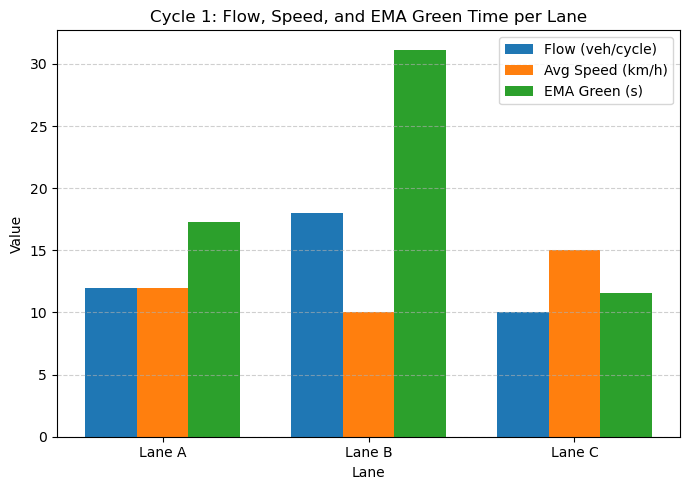

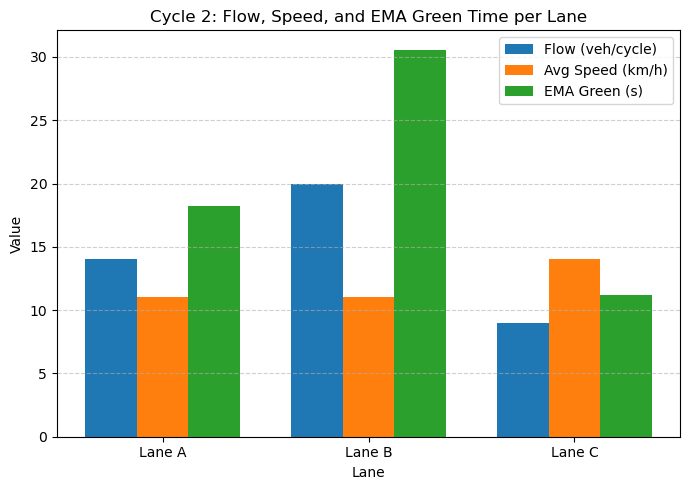

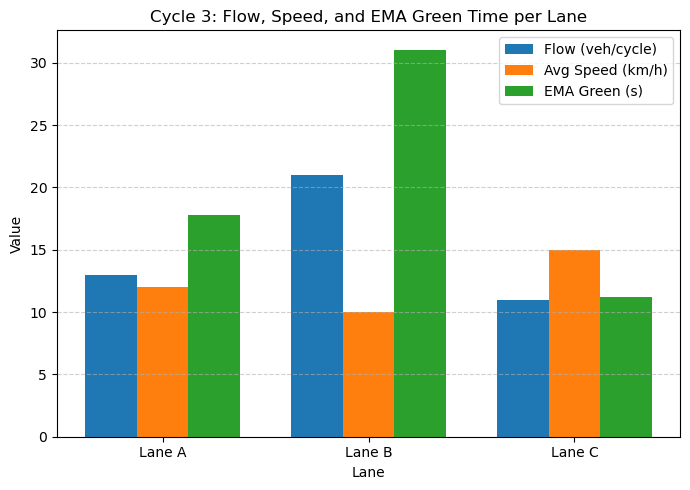

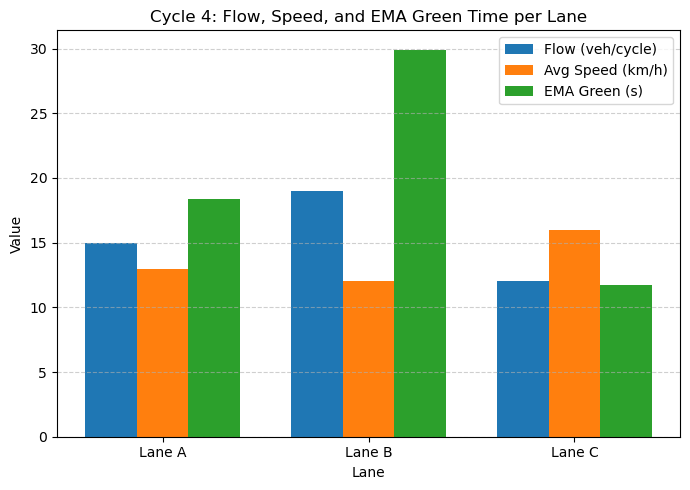

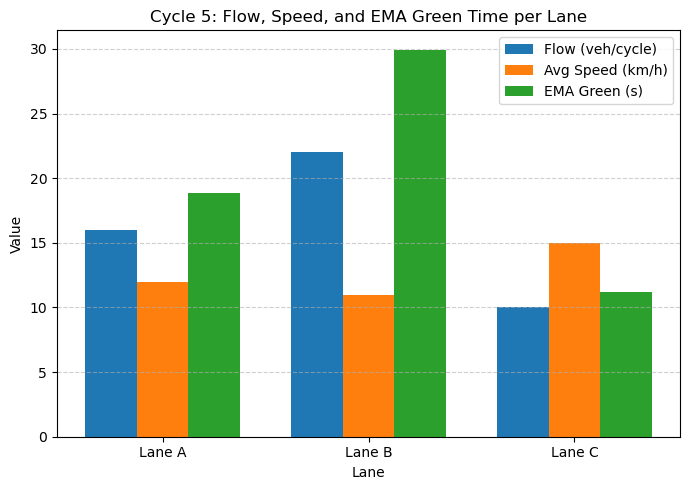

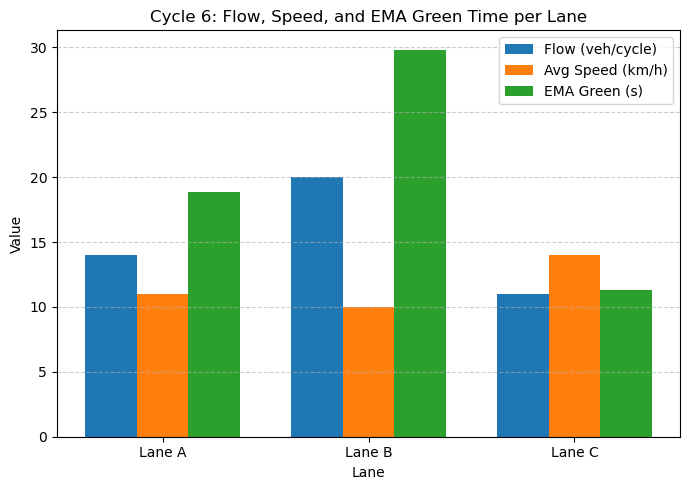

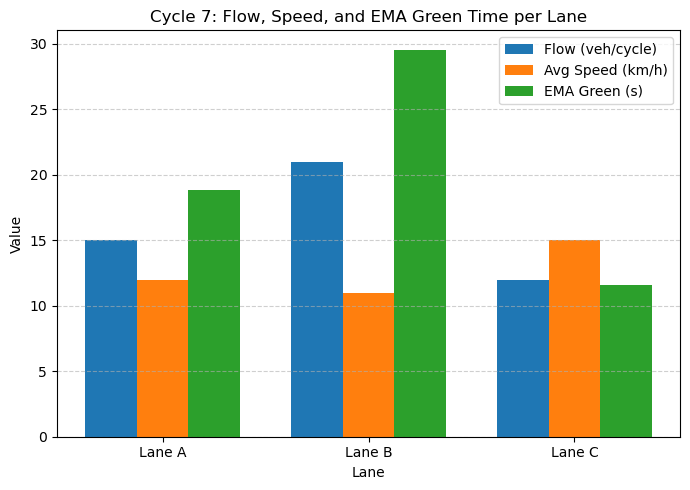

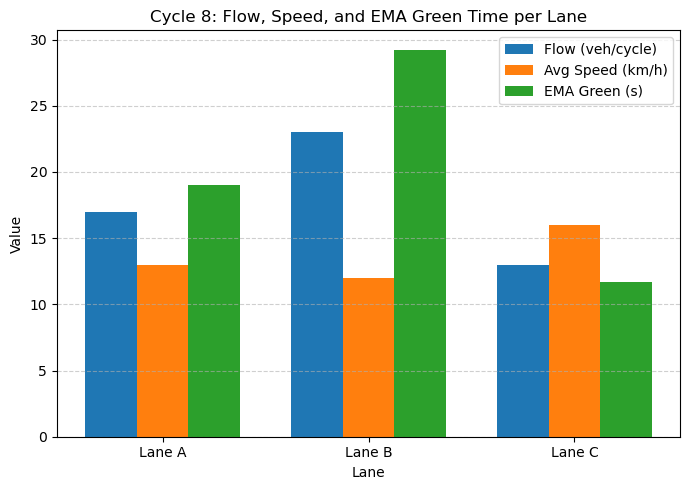

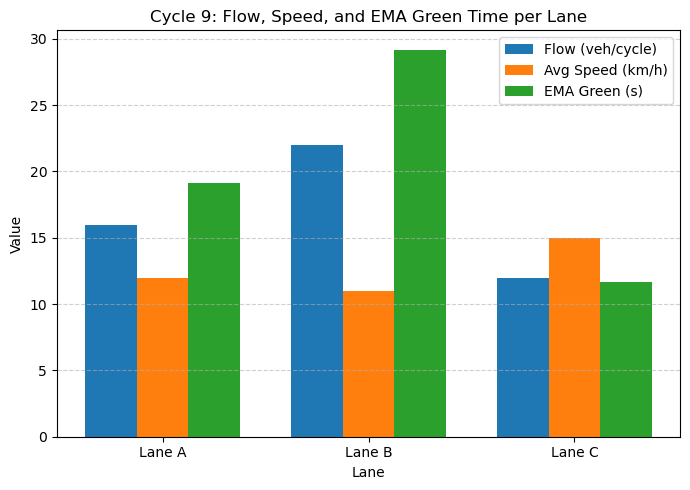

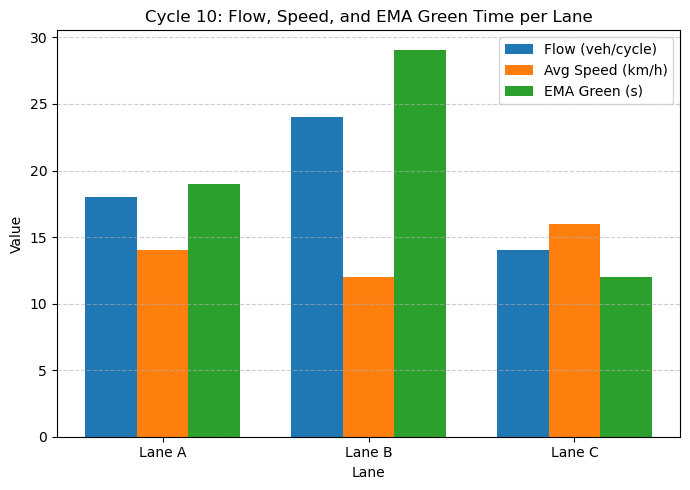

In [19]:
import matplotlib.pyplot as plt
import numpy as np

lanes = ["Lane A", "Lane B", "Lane C"]
cycles = np.arange(1, 11)

# --- Data ---
flow_data = {
    "Lane A": [12,14,13,15,16,14,15,17,16,18],
    "Lane B": [18,20,21,19,22,20,21,23,22,24],
    "Lane C": [10,9,11,12,10,11,12,13,12,14]
}

speed_data = {
    "Lane A": [12,11,12,13,12,11,12,13,12,14],
    "Lane B": [10,11,10,12,11,10,11,12,11,12],
    "Lane C": [15,14,15,16,15,14,15,16,15,16]
}

ema_green_data = {
    "Lane A": [17.31,18.25,17.75,18.38,18.87,18.85,18.88,19.05,19.14,18.96],
    "Lane B": [31.15,30.57,31.05,29.91,29.94,29.83,29.56,29.24,29.18,29.08],
    "Lane C": [11.54,11.18,11.19,11.71,11.19,11.32,11.56,11.72,11.69,11.97]
}

# --- Plot for each cycle ---
for i, cycle in enumerate(cycles):
    flow = [flow_data[lane][i] for lane in lanes]
    speed = [speed_data[lane][i] for lane in lanes]
    emaG = [ema_green_data[lane][i] for lane in lanes]

    x = np.arange(len(lanes))
    width = 0.25

    plt.figure(figsize=(7,5))
    plt.bar(x - width, flow, width, label="Flow (veh/cycle)")
    plt.bar(x, speed, width, label="Avg Speed (km/h)")
    plt.bar(x + width, emaG, width, label="EMA Green (s)")

    plt.xticks(x, lanes)
    plt.xlabel("Lane")
    plt.ylabel("Value")
    plt.title(f"Cycle {cycle}: Flow, Speed, and EMA Green Time per Lane")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


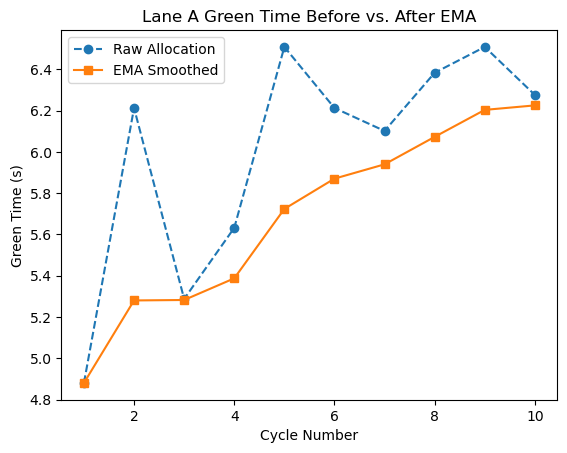

In [ ]:

# --- Plot 2: Green Time Before vs After EMA (Lane A) ---
fig2, ax2 = plt.subplots()
ax2.plot(cycles, green_time["Lane A"], marker="o", linestyle="--", label="Raw Allocation")
ax2.plot(cycles, green_time_ema["Lane A"], marker="s", label="EMA Smoothed")

ax2.set_title("Lane A Green Time Before vs. After EMA")
ax2.set_xlabel("Cycle Number")
ax2.set_ylabel("Green Time (s)")
ax2.legend()


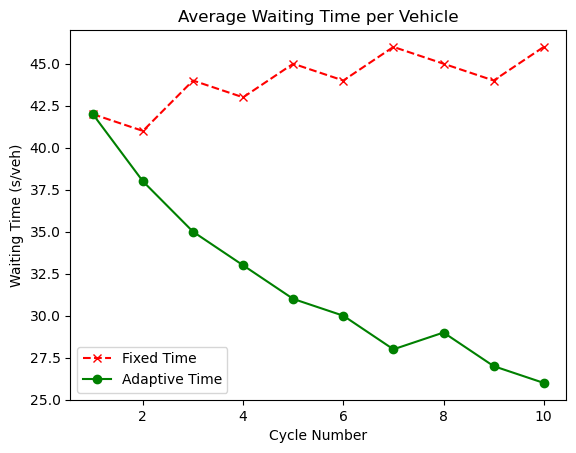

In [ ]:

# --- Plot 3: Waiting time comparison ---
fig3, ax3 = plt.subplots()
ax3.plot(cycles, waiting_fixed, marker="x", color="red", linestyle="--", label="Fixed Time")
ax3.plot(cycles, waiting_adapt, marker="o", color="green", label="Adaptive Time")

ax3.set_title("Average Waiting Time per Vehicle")
ax3.set_xlabel("Cycle Number")
ax3.set_ylabel("Waiting Time (s/veh)")
ax3.legend()

plt.show()
